# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [36]:
# import general libraries for data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# import spark libraries
from pyspark.sql import SparkSession

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Dataset

In [5]:
mini_sparkify_event_data = 'mini_sparkify_event_data.json'

In [7]:
df = spark.read.json(mini_sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## Clean Dataset

`1.` Check for missing values:

In [70]:
# find number of missing values in dataset columns
columns = df.describe().columns[1:]
empy_vals = {}
for column in columns:
    # check for both nan and null values
    empy_vals[column] = (df.select(['userId']).where(isnan(df[column]) | df[column].isNull()).count())

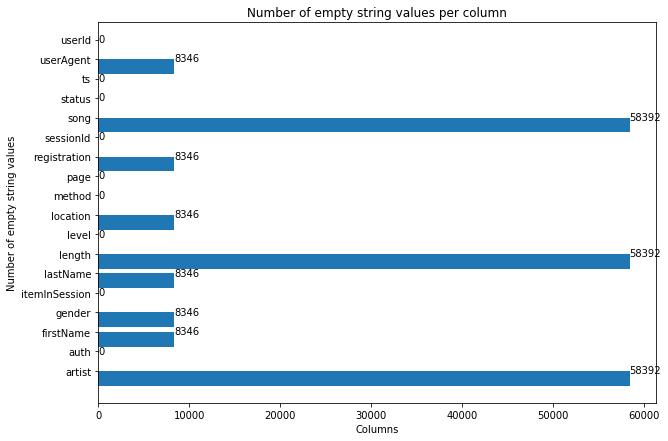

In [76]:
# plot the results with matplotlib

fig, ax = plt.subplots(figsize=(10, 7))  

width = 0.75 # the width of the bars 
ind = np.arange(len(empy_vals))  # the x locations for the groups
ax.barh(ind, list(empy_vals.values()), width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(list(empy_vals.keys()), minor=False)

for i, v in enumerate(list(empy_vals.values())):
    ax.text(v + 3, i + .25, str(v))

plt.title('Number of empty string values per column')
plt.xlabel('Columns')
plt.ylabel('Number of empty string values')      

plt.show()

We see that there are exactly the same numbers of missing values for some of the columns. This may mean that some columns are not filled in for specific kind of events. Let's explore our dataset to prove this:

In [88]:
# select columns with 8346 empty values
df.select(['userId','page', 'userAgent', 'registration', 'location', \
           'firstName', 'lastName', 'gender', 'song', 'length', 'artist']) \
.where(isnan(df['firstName']) | df['firstName'].isNull()).show()

+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|userId| page|userAgent|registration|location|firstName|lastName|gender|song|length|artist|
+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Help|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  n

In [95]:
# select userIds correponding to missing values in page, userAgent, registration
# location, firstName, lastName, gender columns

df.select(['userId']).where(df['firstName'].isNull() & df['userAgent'].isNull() & df['registration'].isNull() \
                            & df['location'].isNull() & df['lastName'].isNull() & df['gender'].isNull())\
.groupby('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+



So we see that rows with empty `userId`, which correspond to users, who are not signed in, have null values for `userAgent, registration, location, firstName, lastName, gender, song, length and artist` columns.

Other rows with empty `song, artist and length` columns probably correspond to other events, which are not related to listening to music, for example, upgrade or downgrade events. Let's look closer at the `page` column values corresponding to rows with empty `song, artist and length` columns.

In [91]:
# select page column values where song, artist and length columns are not null
df.select(['page']).where(df['song'].isNotNull() & df['length'].isNotNull() & df['artist'].isNotNull())\
.groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



We see that `song, artist and length` columns are filled in only for `NextSong` event.

`2.` Check for empty strings in string type colums:

In [25]:
# define list of string columns
columns_str = ['artist', 'auth', 'firstName', \
               'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

In [34]:
# for each column with type string find number of empty string values
empy_str_vals = []
for column in columns_str:
    empy_str_vals.append(df.select(['userId']).where(df[column] == '').count())

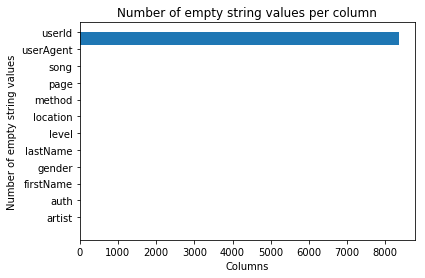

In [52]:
# plot the results with matplotlib

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(empy_str_vals))  # the x locations for the groups
ax.barh(ind, empy_str_vals, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(columns_str, minor=False)

plt.title('Number of empty string values per column')
plt.xlabel('Columns')
plt.ylabel('Number of empty string values')      

plt.show()

As we can see there are __empty string values in `userId` column__, which correspond to the users who are not signed in. As our task is to predict customer churn, we can __remove those records from the analysis__.

`3.` Check for invalid values in numeric columns:

In [57]:
df.describe(['itemInSession', 'length', 'sessionId', 'registration']).show()

+-------+------------------+------------------+-----------------+--------------------+
|summary|     itemInSession|            length|        sessionId|        registration|
+-------+------------------+------------------+-----------------+--------------------+
|  count|            286500|            228108|           286500|              278154|
|   mean|114.41421291448516|249.11718197783478|1041.526554973822|1.535358834085557...|
| stddev|129.76726201141113| 99.23517921058324|726.7762634630808|3.2913216163276587E9|
|    min|                 0|           0.78322|                1|       1521380675000|
|    max|              1321|        3024.66567|             2474|       1543247354000|
+-------+------------------+------------------+-----------------+--------------------+



In [56]:
df.describe(['status', 'ts']).show()

+-------+------------------+--------------------+
|summary|            status|                  ts|
+-------+------------------+--------------------+
|  count|            286500|              286500|
|   mean|210.05459685863875|1.540956889810471...|
| stddev|31.505078488422033| 1.507543960823119E9|
|    min|               200|       1538352117000|
|    max|               404|       1543799476000|
+-------+------------------+--------------------+



As we see numeric columns don't have any invalid values.

`4.` __Perform data cleaning__: the following function removes rows with empty `userId` from the dataset.

In [96]:
def clean_data(df):
    '''
    Function which performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify log events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column
    '''
    
    # remove rows where userId is empty
    df_new = df.filter(df["userId"] != "")
    
    return df_new

# clean data
df = clean_data(df)

# print out first line
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [99]:
df.count() # we see that rows with empty userId are removed from df

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## 1. Preliminary Analysis

Analyze categorical columns ('auth', 'gender', 'level', 'method', 'page'):

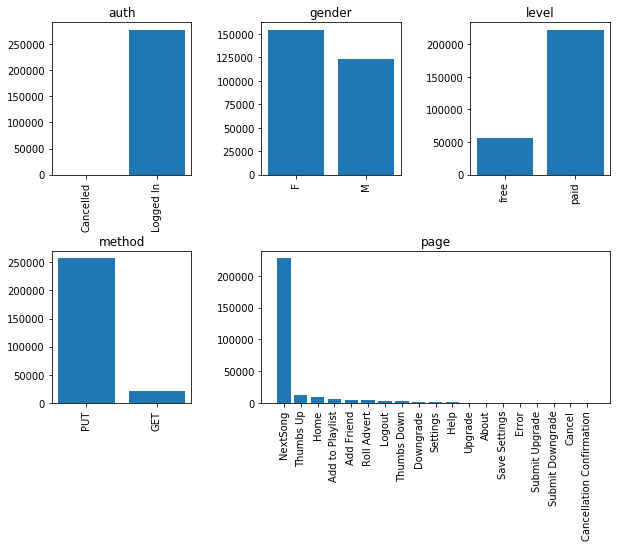

In [151]:
# plot bar charts with values of categorical values

cat_columns = ['auth', 'gender', 'level', 'method']

fig = plt.figure(figsize=(10, 7))
grid = plt.GridSpec(2, 3, hspace=0.5, wspace=0.5)

counter = 0
for cat_column in cat_columns:
    
    value_counts = df.groupBy(cat_column).count().toPandas()
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    x_pos = np.arange(0, len(value_counts))
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    hist_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts[cat_column].values)
    
    hist_ax.set_title(cat_column)
    
    for tick in hist_ax.get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts = df.groupBy('page').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

page_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['page'].values)

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

## 2. Define Churn

Create a column `Churn` to label users who cancelled subscription using `Cancellation Confirmation` event:

## 3. Explore Data

Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.